### OCI Data Science - Useful Tips
<details>
<summary><font size="2">Check for Public Internet Access</font></summary>

```python
import requests
response = requests.get("https://oracle.com")
assert response.status_code==200, "Internet connection failed"
```
</details>
<details>
<summary><font size="2">Helpful Documentation </font></summary>
<ul><li><a href="https://docs.cloud.oracle.com/en-us/iaas/data-science/using/data-science.htm">Data Science Service Documentation</a></li>
<li><a href="https://docs.cloud.oracle.com/iaas/tools/ads-sdk/latest/index.html">ADS documentation</a></li>
</ul>
</details>
<details>
<summary><font size="2">Typical Cell Imports and Settings for ADS</font></summary>

```python
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import logging
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.ERROR)

import ads
from ads.dataset.factory import DatasetFactory
from ads.automl.provider import OracleAutoMLProvider
from ads.automl.driver import AutoML
from ads.evaluations.evaluator import ADSEvaluator
from ads.common.data import ADSData
from ads.explanations.explainer import ADSExplainer
from ads.explanations.mlx_global_explainer import MLXGlobalExplainer
from ads.explanations.mlx_local_explainer import MLXLocalExplainer
from ads.catalog.model import ModelCatalog
from ads.common.model_artifact import ModelArtifact
```
</details>
<details>
<summary><font size="2">Useful Environment Variables</font></summary>

```python
import os
print(os.environ["NB_SESSION_COMPARTMENT_OCID"])
print(os.environ["PROJECT_OCID"])
print(os.environ["USER_OCID"])
print(os.environ["TENANCY_OCID"])
print(os.environ["NB_REGION"])
```
</details>

## Import Libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plot
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## Data Exploration

The goals of Data Exploration are to identify what data you have and what is usable, identify issues such as missing values and outliers, and to form ideas of new features that could be calculated (Feature Engineering). Later on we'll use the knowledge that we gain during Data Exploration to decide which data transformations to perform.

* Pandas is a library that's used for working with data, e.g. displaying it and doing data transformations.
* Numpy is a library to work with arrays and for calculations.
* Sklearn is the standard Python library for machine learning. It provides many unsupervised and supervised learning algorithms.
* Seaborn is a Python data visualization library based on matplotlib.

### Load Training Data

In [3]:
alldata = pd.read_csv('./housesales.csv')

Check shape of data:

In [4]:
alldata.shape

(1460, 81)

Review values:

In [5]:
alldata['SalePrice'][:10]

0    208500
1    181500
2    223500
3    140000
4    250000
5    143000
6    307000
7    200000
8    129900
9    118000
Name: SalePrice, dtype: int64

Check for empty values

In [6]:
alldata['SalePrice'].isnull().sum()

0

Check price range

In [7]:
minPrice = alldata['SalePrice'].min()
maxPrice = alldata['SalePrice'].max()

print('Min Sales Price (%d) - Max Sales Price (%d)' % (minPrice,maxPrice))

Min Sales Price (34900) - Max Sales Price (755000)


This tells us that SalePrice is an integer and has numbers in the range that we would expect from house prices. There are no empty values. We could see however that the price range is very wide from a 34900 up to 755000. This would require to scale the price to allow the algorithm to learn better.

Which columns will we select as input features for our model?

In [8]:
alldata.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

As we can see there are too many, maybe more useful will be to separate them and see only the numerical and the categorical ones.

Show sample of numerical columns

In [10]:
alldata.select_dtypes(include=[np.number])

Id  MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  \
0        1          60         65.0     8450            7            5   
1        2          20         80.0     9600            6            8   
2        3          60         68.0    11250            7            5   
3        4          70         60.0     9550            7            5   
4        5          60         84.0    14260            8            5   
...    ...         ...          ...      ...          ...          ...   
1455  1456          60         62.0     7917            6            5   
1456  1457          20         85.0    13175            6            6   
1457  1458          70         66.0     9042            7            9   
1458  1459          20         68.0     9717            5            6   
1459  1460          20         75.0     9937            5            6   

      YearBuilt  YearRemodAdd  MasVnrArea  BsmtFinSF1  ...  WoodDeckSF  \
0          2003          2003       196.0         706  ...           0   
1          1976          1976         0.0         978  ...         298   
2          2001          2002       162.0         486  ...           0   
3          1915          1970         0.0         216  ...           0   
4          2000          2000       350.0         655  ...         192   
...         ...           ...         ...         ...  ...         ...   
1455       1999          2000         0.0           0  ...           0   
1456       1978          1988       119.0         790  ...         349   
1457       1941          2006         0.0         275  ...           0   
1458       1950          1996         0.0          49  ...         366   
1459       1965          1965         0.0         830  ...         736   

      OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea  MiscVal  \
0              61              0          0            0         0        0   
1               0              0          0            0         0        0   
2              42              0          0            0         0        0   
3              35            272          0            0         0        0   
4              84              0          0            0         0        0   
...           ...            ...        ...          ...       ...      ...   
1455           40              0          0            0         0        0   
1456            0              0          0            0         0        0   
1457           60              0          0            0         0     2500   
1458            0            112          0            0         0        0   
1459           68              0          0            0         0        0   

      MoSold  YrSold  SalePrice  
0          2    2008     208500  
1          5    2007     181500  
2          9    2008     223500  
3          2    2006     140000  
4         12    2008     250000  
...      ...     ...        ...  
1455       8    2007     175000  
1456       2    2010     210000  
1457       5    2010     266500  
1458       4    2010     142125  
1459       6    2008     147500  

[1460 rows x 38 columns]

Show a list of categorical columns

In [11]:
alldata.select_dtypes(exclude=np.number).columns.tolist()

['MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'SaleType',
 'SaleCondition']

Show a sample of categorical variables

In [12]:
alldata.select_dtypes(exclude=[np.number])

MSZoning Street Alley LotShape LandContour Utilities LotConfig LandSlope  \
0          RL   Pave   NaN      Reg         Lvl    AllPub    Inside       Gtl   
1          RL   Pave   NaN      Reg         Lvl    AllPub       FR2       Gtl   
2          RL   Pave   NaN      IR1         Lvl    AllPub    Inside       Gtl   
3          RL   Pave   NaN      IR1         Lvl    AllPub    Corner       Gtl   
4          RL   Pave   NaN      IR1         Lvl    AllPub       FR2       Gtl   
...       ...    ...   ...      ...         ...       ...       ...       ...   
1455       RL   Pave   NaN      Reg         Lvl    AllPub    Inside       Gtl   
1456       RL   Pave   NaN      Reg         Lvl    AllPub    Inside       Gtl   
1457       RL   Pave   NaN      Reg         Lvl    AllPub    Inside       Gtl   
1458       RL   Pave   NaN      Reg         Lvl    AllPub    Inside       Gtl   
1459       RL   Pave   NaN      Reg         Lvl    AllPub    Inside       Gtl   

     Neighborhood Condition1  ... GarageType GarageFinish GarageQual  \
0         CollgCr       Norm  ...     Attchd          RFn         TA   
1         Veenker      Feedr  ...     Attchd          RFn         TA   
2         CollgCr       Norm  ...     Attchd          RFn         TA   
3         Crawfor       Norm  ...     Detchd          Unf         TA   
4         NoRidge       Norm  ...     Attchd          RFn         TA   
...           ...        ...  ...        ...          ...        ...   
1455      Gilbert       Norm  ...     Attchd          RFn         TA   
1456       NWAmes       Norm  ...     Attchd          Unf         TA   
1457      Crawfor       Norm  ...     Attchd          RFn         TA   
1458        NAmes       Norm  ...     Attchd          Unf         TA   
1459      Edwards       Norm  ...     Attchd          Fin         TA   

     GarageCond PavedDrive PoolQC  Fence MiscFeature SaleType SaleCondition  
0            TA          Y    NaN    NaN         NaN       WD        Normal  
1            TA          Y    NaN    NaN         NaN       WD        Normal  
2            TA          Y    NaN    NaN         NaN       WD        Normal  
3            TA          Y    NaN    NaN         NaN       WD       Abnorml  
4            TA          Y    NaN    NaN         NaN       WD        Normal  
...         ...        ...    ...    ...         ...      ...           ...  
1455         TA          Y    NaN    NaN         NaN       WD        Normal  
1456         TA          Y    NaN  MnPrv         NaN       WD        Normal  
1457         TA          Y    NaN  GdPrv        Shed       WD        Normal  
1458         TA          Y    NaN    NaN         NaN       WD        Normal  
1459         TA          Y    NaN    NaN         NaN       WD        Normal  

[1460 rows x 43 columns]

What can we conclude about the columns?

There are many input features that we could potentially use. Some of these columns are self explanatory, others not so much. To understand what each column means, have a look at data_description.txt for background.

Which columns would we select intuitively?

To start with, let's first take an intuitive approach. Ask yourself:

"Which of these columns is likely of value to predict Sale Price?" "Which factors of a house would I look at yourself when making a buying decision?" "Is enough information available in these columns, are there any empty values?"

Imagine that we've decide that we believe the following features are relevant: GrLivArea size of living area, TotalBsmtSF size of basement, OverallQual overall quality category, YearBuilt year house was built MSZoning A=Agriculture, C=Commercial, RH=Residential High Density, etc.

Are the columns we intuitively selected also actually correlated with the Sale Price?

Let's test our theories that these input features are correlated with Sale Price. We'll start with the numerical variables first: GrLivArea, TotalBsmtSF, OverallQual and YearBuilt. Because all of these are numerical continuous attributes, we can use scatter plots here

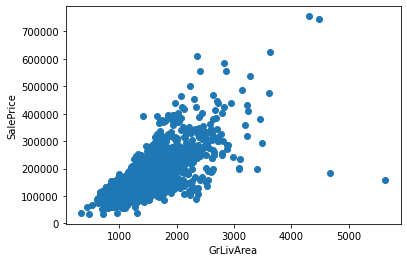

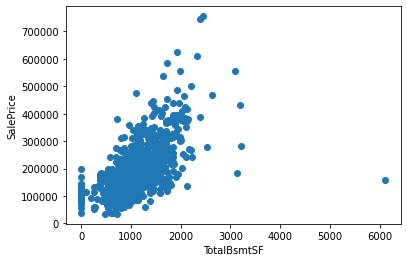

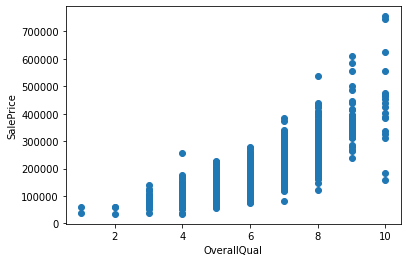

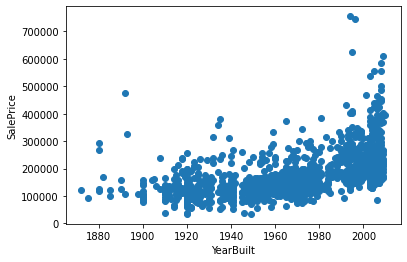

In [13]:
plot.scatter(alldata.GrLivArea, alldata.SalePrice)
plot.xlabel("GrLivArea")
plot.ylabel("SalePrice")
plot.show()
plot.scatter(alldata.TotalBsmtSF, alldata.SalePrice)
plot.xlabel("TotalBsmtSF")
plot.ylabel("SalePrice")
plot.show()
plot.scatter(alldata.OverallQual, alldata.SalePrice)
plot.xlabel("OverallQual")
plot.ylabel("SalePrice")
plot.show()
plot.scatter(alldata.YearBuilt, alldata.SalePrice)
plot.xlabel("YearBuilt")
plot.ylabel("SalePrice")
plot.show()

We can conclude that: GrLivArea: There is a linear correlation with SalePrice; We can draw a straight line from the bottom-left to the top-right. TotalBsmtSF: It appears to be an relationship between TotalBsmtSF and SalePrice too but not that obvious. It seems a higher basement sizes lead to higher prices but we could notice that there are some outliers. OveralQual: As expected, there is a higher sales price when overal quality perception is higher. But that is not nessary for the entire price range. Probably the quality of the house is not enough and the price would depend on the location or the zoning as well. YearBuilt: This relationship is a little less obvious, but there's a trend for higher prices for more recent construction.

These attributes appear to be of predictive value and we definitely want to keep them in our training set!

On another note, we see several outliers. In particular, the attribute GrLivArea shows that there are some houses with exceptionally large living areas given their price. We could notice this also for the TotalBsmtSF. Generally it is recommended to build the initial model with all the available values first and then start removing outliers to see if this would improve the prediction and make the model generalize better.

Is the categorical attribute MSZoning also correlated with SalePrice?

This attribute contains the type of property (A=Agriculture, C=Commercial, RH=Residential High Density, et cetera). Correlation between a categorical and a continuous attribute (SalePrice) can be visualized as a boxplot.

(-0.5, 4.5, 0.0, 800000.0)

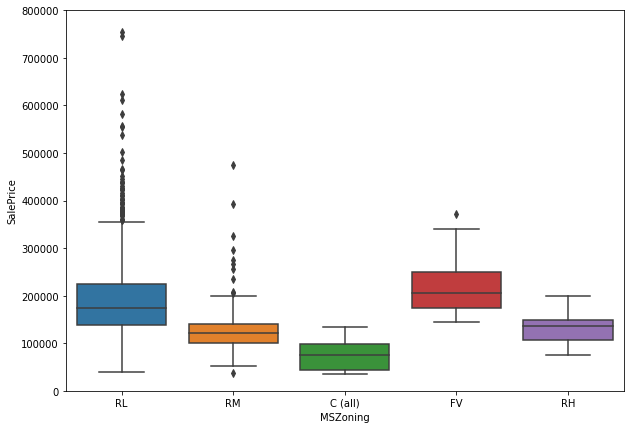

In [14]:
var = 'MSZoning'
data = pd.concat([alldata['SalePrice'], alldata[var]], axis=1)
f, ax = plot.subplots(figsize=(10, 7))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000)

What can we conclude from this? The boxplots for the various types of properties look very different. From the plot we could see that the residential areas seems to be more expensive as expected than commercial but the price range is high. So, again, MSZoning appears to contain important information to predict the price.

What is the relationship between Neighborhood and SalePrice?

Let's explore also the relationship of the Neighborhood to the price. We can plot the data using the same technique.

(-0.5, 24.5, 0.0, 800000.0)

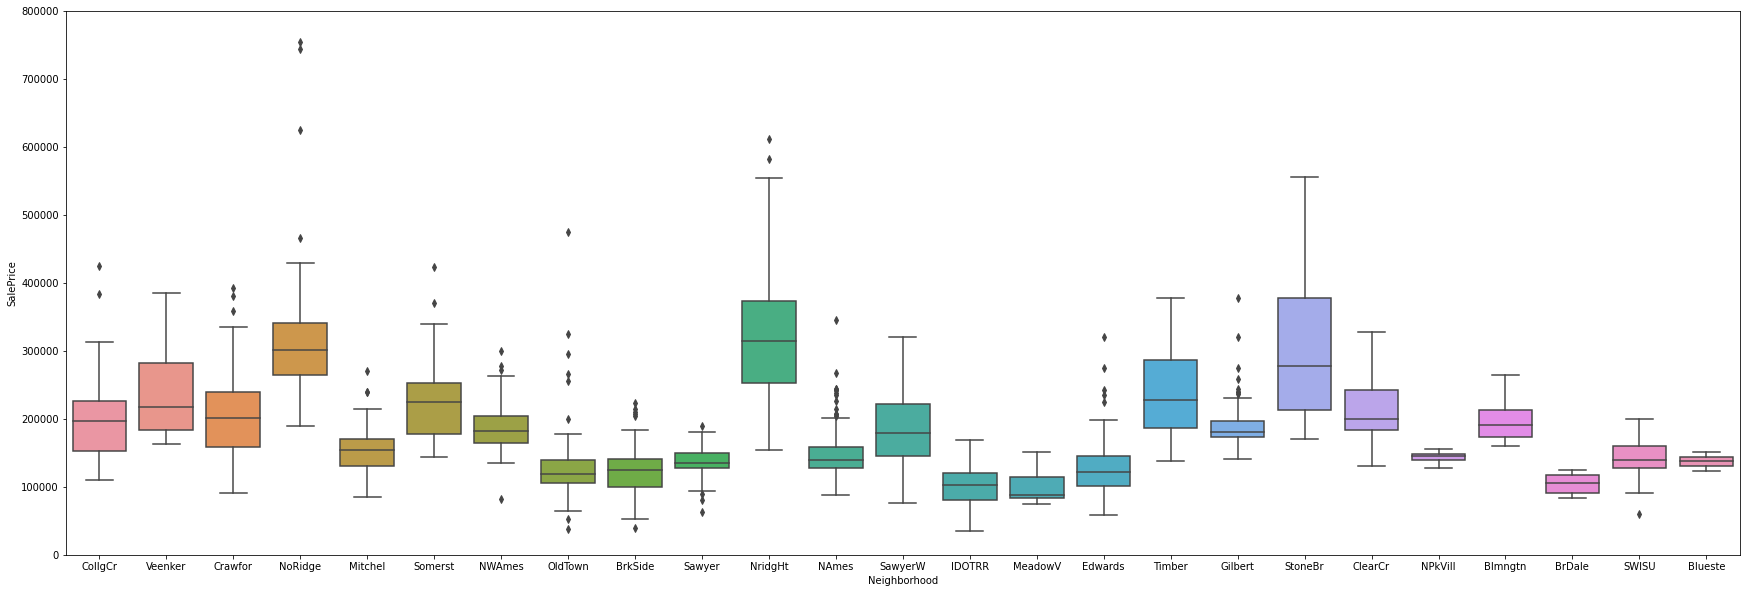

In [15]:
var = 'Neighborhood'
data = pd.concat([alldata['SalePrice'], alldata[var]], axis=1)
f, ax = plot.subplots(figsize=(30, 10))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000)

The plot is not necessary conclusive, but it appears that as expected some areas are more expensive than others. As such we should keep this columns and use it in the model. Notice that some areas shown very large range of prices and spikes like NridgHt or StoneBr or very large outliers like in NoRidge with prices more than double as the usual range for that neighborhood. After the initial model build you could try to remove these outliers and test if the model would have better performance.

A different approach: Systematically checking for correlation between input features and our target

It becomes clear that manually investigating all of the attributes this way is very time consuming. Therefore, let's take a more systematic approach. Ideally, we would like to see the correlation between all input attributes and the target SalePrice.

In [16]:
corr = alldata.corr(method='spearman')
corr.sort_values(["SalePrice"], ascending = False, inplace = True)
corr.SalePrice

SalePrice        1.000000
OverallQual      0.809829
GrLivArea        0.731310
GarageCars       0.690711
YearBuilt        0.652682
GarageArea       0.649379
FullBath         0.635957
TotalBsmtSF      0.602725
GarageYrBlt      0.593788
1stFlrSF         0.575408
YearRemodAdd     0.571159
TotRmsAbvGrd     0.532586
Fireplaces       0.519247
OpenPorchSF      0.477561
LotArea          0.456461
MasVnrArea       0.421309
LotFrontage      0.409076
WoodDeckSF       0.353802
HalfBath         0.343008
BsmtFinSF1       0.301871
2ndFlrSF         0.293598
BedroomAbvGr     0.234907
BsmtFullBath     0.225125
BsmtUnfSF        0.185197
ScreenPorch      0.100070
MoSold           0.069432
3SsnPorch        0.065440
PoolArea         0.058453
MSSubClass       0.007192
BsmtHalfBath    -0.012189
Id              -0.018546
YrSold          -0.029899
BsmtFinSF2      -0.038806
MiscVal         -0.062727
LowQualFinSF    -0.067719
OverallCond     -0.129325
KitchenAbvGr    -0.164826
EnclosedPorch   -0.218394
Name: SalePr

The conclusion is that our intuition of thinking that TotalBsmtSF, OverallQual, GrLivArea and YearBuilt are of importance, was correct. However, there are other features listed as high correlation, such as GarageCars, GarageArea and Fullbath.

Here's a list of the features that are most correlated with our target:

* OverallQual: Rates the overall material and finish of the house (1 = Very Poor, 10 = Very Excellent)
* GrLivArea: Above grade (ground) living area square feet
* GarageCars: Size of garage in car capacity
* GarageArea: Size of garage in square feet
* TotalBsmtSF: Total square feet of basement area
* 1stFlrSF: First Floor square feet
* FullBath: Full bathrooms above grade
* TotRmsAbvGrd: Total rooms above grade (does not include bathrooms)
* YearBuilt: Original construction date


Is there data missing from some of the columns?

Many machine learning models are unable to handle missing data. We have to find out how much data is missing.

At the moment of replacing missing data, we should first find out whether that would cause some kind of distortion in the data and have a negative effect on model quality.

Therefore, we have to see if the missing data follows certain patterns.

Check how many Empty values each column has, and compute the percentage of the total number of rows.

In [17]:
total = alldata.isnull().sum().sort_values(ascending=False)
percent = (alldata.isnull().sum()/alldata.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

Total   Percent
PoolQC         1453  0.995205
MiscFeature    1406  0.963014
Alley          1369  0.937671
Fence          1179  0.807534
FireplaceQu     690  0.472603
LotFrontage     259  0.177397
GarageCond       81  0.055479
GarageType       81  0.055479
GarageYrBlt      81  0.055479
GarageFinish     81  0.055479
GarageQual       81  0.055479
BsmtExposure     38  0.026027
BsmtFinType2     38  0.026027
BsmtFinType1     37  0.025342
BsmtCond         37  0.025342
BsmtQual         37  0.025342
MasVnrArea        8  0.005479
MasVnrType        8  0.005479
Electrical        1  0.000685
Utilities         0  0.000000

There are a lot of attributes with missing values. This is especially the case for attributes PoolQC, MiscFeature, Alley, Fence and FireplaceQu.

Let's investigate the attributes with most missing values in detail

Have a look at the data description for these columsn in particular. The description of the attribute PoolQC (pool quality) is as follows:

* Ex - Excellent
* Gd - Good
* TA - Average/Typical
* Fa - Fair
* NA - No Pool

It seems sensible to assume that most houses don't have pools and therefore missing values simply mean "No Pool". Therefore we make a note to replace those missing values with "NA". Similarly, we make a note to replace the missing values for MiscFeature, Alley, Fence and FireplaceQu with "NA".

The next attribute with many hidden values is LotFrontage, which means "Linear feet of street connected to property". This is a continuous measure, and we choose that we will replace missing values by with the mean of the existing values. We'll see more of this in the Data Preparation stage.



Check the distribution of the Target variable

It's important that the target variable follows Normal Probability distribution. If it does not, this will negatively impact the model's performance. We can check for this using a histogram, and including a normal probability plot. The Seaborn library does this for us.

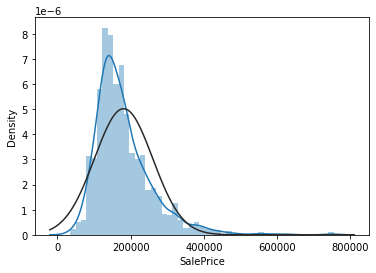

<Figure size 432x288 with 0 Axes>

In [19]:
sns.distplot(alldata['SalePrice'], fit=norm);
fig = plot.figure()

We can conclude from this that the values of the Target variable currently deviate from the Normal Distribution. You see that it is left skewed. The regression algorithms that we will use later on has problems with such a distribution. We will have to address this problem.

## Data Preparation

During Data Exploration, we have realized that several changes must be made to the dataset. Data Preparation is a logical result of Data Exploration; we will now take action based on the insights that we gained earlier.

1. Update missing values

In the previous topic (identifying Missing Values) we made the decision that:

We want to replace the missing values of PoolQC, MiscFeature, Alley, Fence and FireplaceQu with "NA". We will replace missing values of LotFrontage with the mean of the existing values. 

In [20]:
alldata = alldata.fillna({"PoolQC": "NA"})
alldata = alldata.fillna({"MiscFeature": "NA"})
alldata = alldata.fillna({"Alley": "NA"})
alldata = alldata.fillna({"Fence": "NA"})
alldata = alldata.fillna({"FireplaceQu": "NA"})
meanlot = alldata['LotFrontage'].mean()
alldata = alldata.fillna({"LotFrontage": meanlot})
alldata = alldata.dropna()

Handling Outliers

Do you remember that the scatter chart for GrLivArea showed several outliers? Let's remove these two outliers, by identifying the houses with the highest GrLivArea.

Show the IDs of the houses with the highest GrLivArea.

In [21]:
alldata.sort_values(by = 'GrLivArea', ascending = False)[:2]

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
1298  1299          60       RL        313.0    63887   Pave    NA      IR3   
523    524          60       RL        130.0    40094   Pave    NA      IR1   

     LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal  \
1298         Bnk    AllPub  ...      480     Gd    NA          NA       0   
523          Bnk    AllPub  ...        0     NA    NA          NA       0   

     MoSold YrSold  SaleType  SaleCondition  SalePrice  
1298      1   2008       New        Partial     160000  
523      10   2007       New        Partial     184750  

[2 rows x 81 columns]

In [ ]:
Remove the Outliers

We are also plotting the chart again to check that the outliers have disappeared.

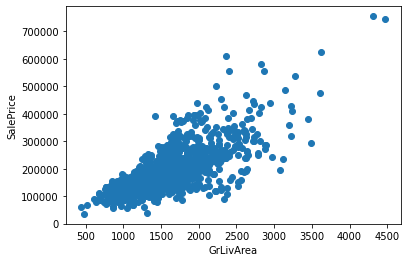

In [22]:
alldata = alldata.drop(alldata[alldata['Id'] == 1299].index)
alldata = alldata.drop(alldata[alldata['Id'] == 524].index)
plot.scatter(alldata.GrLivArea, alldata.SalePrice)
plot.xlabel("GrLivArea")
plot.ylabel("SalePrice")
plot.show()

You notice that those outliers have disappeared.

Handling the skewed distribution of the Target variable

Do you remember that the histogram of SalePrice showed a positive skew? We can solve this problem by converting the target variable. We use a -log- transformation to make the variable fit normal distribution. Let's make the log transformation and show the histogram again to check the result.

In [23]:
y = np.log(alldata['SalePrice'])
sns.distplot(y, fit=norm)
fig = plot.figure()

<Figure size 432x288 with 0 Axes>

You will notice that the sales price now follows a normal distribution. We will use the newly created y variable later to fit our model.

Removing irrelevant features

In any case we will remove the ID column, which does not carry any predictive value. We will also remove the attributes that showed very low correlation with SalePrice during Data Exploration. Note that this is a fairly brute approach, but it is again sufficient for our exercise. After the first model build, you could start adding back some of the features and observe if the model will generalize better.

In [24]:
alldata.drop("Id", axis = 1, inplace = True)
alldata.drop("BsmtFullBath", axis = 1, inplace = True)
alldata.drop("BsmtUnfSF", axis = 1, inplace = True)
alldata.drop("ScreenPorch", axis = 1, inplace = True)
alldata.drop("MoSold", axis = 1, inplace = True)
alldata.drop("3SsnPorch", axis = 1, inplace = True)
alldata.drop("PoolArea", axis = 1, inplace = True)
alldata.drop("MSSubClass", axis = 1, inplace = True)
alldata.drop("YrSold", axis = 1, inplace = True)
alldata.drop("BsmtFinSF2", axis = 1, inplace = True)
alldata.drop("MiscVal", axis = 1, inplace = True)
alldata.drop("LowQualFinSF", axis = 1, inplace = True)
alldata.drop("OverallCond", axis = 1, inplace = True)
alldata.drop("KitchenAbvGr", axis = 1, inplace = True)
alldata.drop("EnclosedPorch", axis = 1, inplace = True)

Separating Target and Input Features

Scikit Learn expects that we deliver the data for training in two parts:

* A dataset with a single column, the target, in this case SalePrice. We did this already earlier by taking the log of the SalePrice and storing it in "y" variable.
* A dataset with all the input columns, in this case all columns apart from SalePrice. We will place this in variable "X". 

Get all the data with the exception of the SalePrice and place it in variable X:

In [25]:
X = alldata.drop(['SalePrice'], axis=1)

Convert categorical values to numbers

Most ML algorithms can only work with numbers. Therefore we should convert categories to numbers first.

For all attributes we will assume that they are Nominal (as opposed to Ordinal), meaning that there's no order/sequence in the values that it can take. The go-to method to encode Nominal categorical values is Onehot Encoding. This will convert each separate value of a category into its own column that can take a value of 1 or 0. The Pandas get_dummies function does OneHot encoding.

You will see that after this the SaleType column has been converted into SaleType_ConLw, SaleType_New, et cetera. The dataset now only has numerical values.

In [26]:
X = pd.get_dummies(X)
X.head()

LotFrontage  LotArea  OverallQual  YearBuilt  YearRemodAdd  MasVnrArea  \
0         65.0     8450            7       2003          2003       196.0   
1         80.0     9600            6       1976          1976         0.0   
2         68.0    11250            7       2001          2002       162.0   
3         60.0     9550            7       1915          1970         0.0   
4         84.0    14260            8       2000          2000       350.0   

   BsmtFinSF1  TotalBsmtSF  1stFlrSF  2ndFlrSF  ...  SaleType_ConLw  \
0         706          856       856       854  ...               0   
1         978         1262      1262         0  ...               0   
2         486          920       920       866  ...               0   
3         216          756       961       756  ...               0   
4         655         1145      1145      1053  ...               0   

   SaleType_New  SaleType_Oth  SaleType_WD  SaleCondition_Abnorml  \
0             0             0            1                      0   
1             0             0            1                      0   
2             0             0            1                      0   
3             0             0            1                      1   
4             0             0            1                      0   

   SaleCondition_AdjLand  SaleCondition_Alloca  SaleCondition_Family  \
0                      0                     0                     0   
1                      0                     0                     0   
2                      0                     0                     0   
3                      0                     0                     0   
4                      0                     0                     0   

   SaleCondition_Normal  SaleCondition_Partial  
0                     1                      0  
1                     1                      0  
2                     1                      0  
3                     0                      0  
4                     1                      0  

[5 rows x 273 columns]

##  Building the model

We will build a simple Linear Regression model. We will use the Scikit-Learn library for this.

1. Split Train and Test data so we can validate the model later

After building the model, we will want to test its performance against new data. It's important that this data has not been seen before during the model training. To achieve this we have to reserve part of our dataset for testing, which will be removed from the training phase.

We'll reserve 20% of the total dataset for testing. The random_state variable is for initializng the randomizer. By hardcoding it here we make sure that we select the same records everytime that we run the script.

After this we will have 4 variables:

* X_train: The input features of the training dataset.
* X_test: The input features of the test dataset.
* y_train: The target of the training dataset.
* y_train: The target of the test dataset.\

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=63, test_size=.20)

Build the model

Now we're ready to build the model (on the training data only). Building the model is also called "fitting".

In [28]:
lr = linear_model.LinearRegression()
model = lr.fit(X_train, y_train)

## Verifying the performance of the model

How accurate is our model? We will use the Test dataset for this.

First apply the predictions on the Test dataset

In [29]:
y_predicted = model.predict(X_test)

Look at the prediction of one particular house

From the given test set we get the data of one house and check the predicted value.

In [30]:
y_predicted[0]

11.992319354524527

Convert the value back to an actual house price

You would notice that the price above is strange, it shows a number that doesn't seem to be a normal house Sales Price. If you remember we scaled the SalePrice by using np.log(SalePrice) to get the prices in smaller range and help the algorithm generalize and learn better. To get the real price now we need to revert back this scale. To do so we have to use np.exp.

In [31]:
np.exp(y_predicted[0])

161509.51794052523

An intuitive, visual approach to verification

To verify the quality of the predictions, let's first use an intuitive visual approach, which works well for linear regression models. For this we will display in one plot:

* a. The actual SalePrice (according to the original data in the Test dataset)
* b. The predicted SalePrice (the value according to our model)
We're plotting this as a scatter.

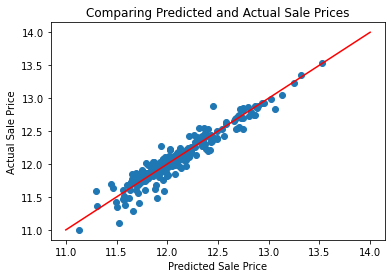

In [32]:
plot.scatter(y_predicted, y_test)
plot.xlabel('Predicted Sale Price')
plot.ylabel('Actual Sale Price')
plot.title('Comparing Predicted and Actual Sale Prices')
plot.plot(range(11, 15), range(11, 15), color="red")
plot.show()

In ideal circumstances we'd like to see the predictions falling on the line of actual values. This would mean that Predicted and Actual Sale Prices are the same. In our case, although the points are not oriented in a perfectly straight line, the model appears to be fairly accurate.

A measurable approach to verification

How can we express the accuracy of the model in a more mathematical way? For that we use a quality metric, in this case we could use RMSE.

RMSE measures the distance between the predictions and the actual values. A lower value for RMSE means a higher accuracy.

RMSE by itself is not easy to interpret, but it can be used to compare different versions of a model, to see whether a change you've made has resulted in an improvement. Scikit-Learn has a function to calculate RMSE.

Note: Root-mean-square_deviation - see: https://en.wikipedia.org/wiki/Root-mean-square_deviation

In [33]:
print('RMSE: ', mean_squared_error(y_test, y_predicted))

RMSE:  0.012609759703155723


## Store the model in the catalog and deploy it

If we want applications/business processes to make good use of our model, then we need to deploy it first. We start by publishing the model to the model catalog. The following will serialize the model along with some other artifacts and store it in the catalog under the name "house-price-model"

In [40]:
import ads
from ads.common.model_artifact import ModelArtifact
from ads.common.model_export_util import prepare_generic_model
import os
from os import path
from joblib import dump
import cloudpickle
ads.set_auth(auth='resource_principal')
path_to_model_artifacts = "house-price"
generic_model_artifact = prepare_generic_model(
    path_to_model_artifacts,
    force_overwrite=True,
    function_artifacts=False,
    data_science_env=True)
with open(path.join(path_to_model_artifacts, "model.pkl"), "wb") as outfile: cloudpickle.dump(model, outfile)
catalog_entry = generic_model_artifact.save(display_name='house-price-model',
    description='Model to predict house prices')

INFO:ADS:We give you the option to specify a different inference conda environment for model deployment purposes. By default it is assumed to be the same as the conda environment used to train the model. If you wish to specify a different environment for inference purposes, please assign the path of a published or data science conda environment to the optional parameter `inference_conda_env`. 
INFO:ADS:{
  "git_branch": "None",
  "git_commit": "None",
  "repository_url": "None",
  "script_dir": "/home/datascience/demos/lin_reg_house_sales/house-price",
  "training_script": "None"
}


Deploy the model

Now we're going to deploy this model to its own compute instance. This will take the model from the catalog and create a runtime version of it that's ready to receive requests. This uses normal OCI compute shapes. Next, choose "Create Deployment".

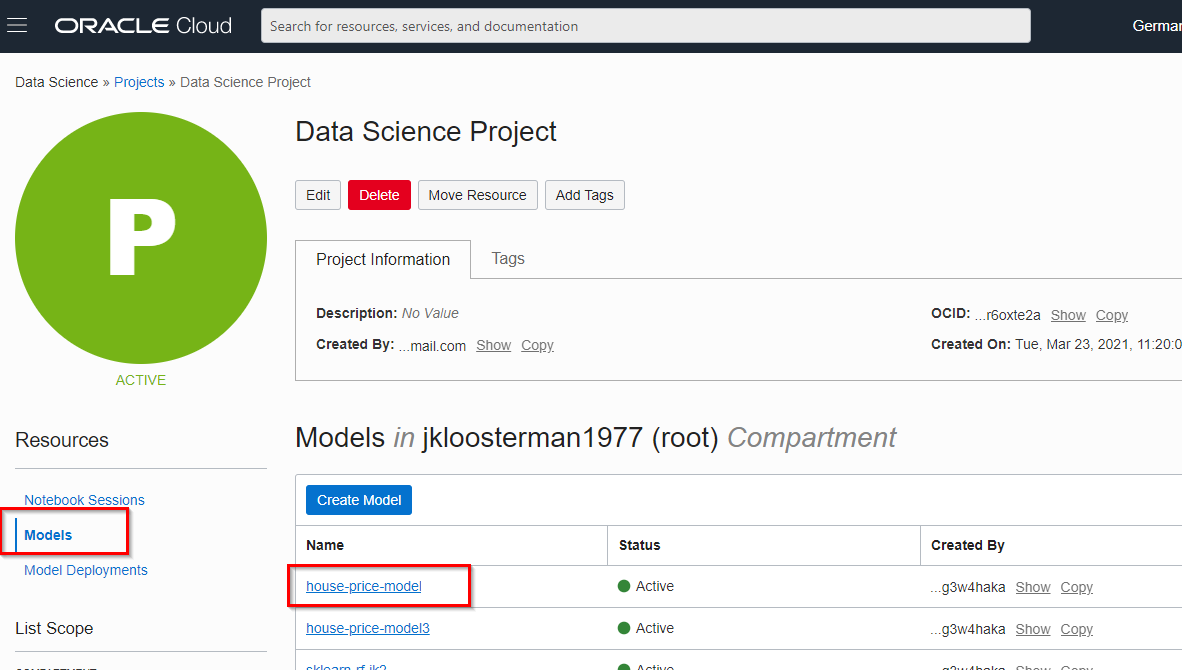

In [39]:
#load the following image
from IPython.display import Image
Image("/home/datascience/demos/lin_reg_house_sales/go-to-model-catalog.png")

* Give the model deployment a name, e.g. "house price model deployment"
* Choose the right model (house-price-model)
* Choose a shape, one instance of VM.Standard2.1 is sufficient. Note that we could have chosen multiple instances, this is useful for models that are used very intensively.

Finally, submit the deployment. This should take about 10 minutes. Finally, you should see that the compute instance is active.

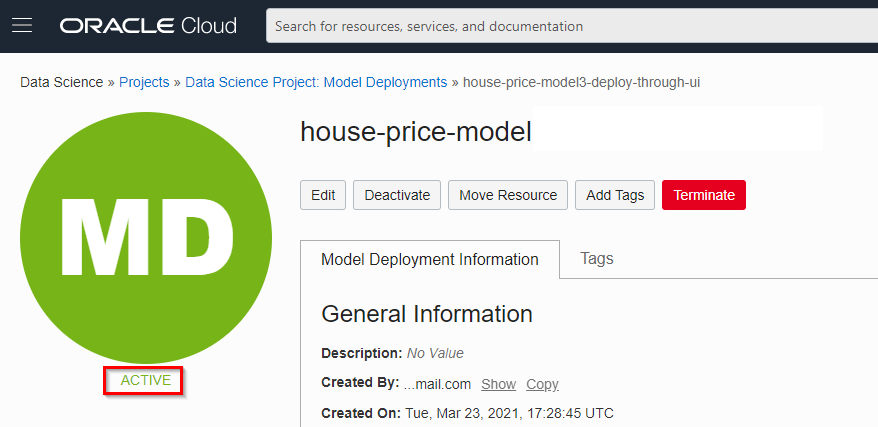

In [38]:
#load the following image
from IPython.display import Image
Image("/home/datascience/demos/lin_reg_house_sales/deployed-model.png")